
## Classification of Items in School Budget using Logistic Regression

This is a case study that will explore a problem related to school district budgeting. By building a supervised machine learning model in python to automatically classify items in a school's budget, it makes it easier and faster for schools to compare their spending with other schools.

### Problem Summary:
Budgets for schools and school districts are huge, complex, and unwieldy. It's no easy task to digest where and how schools are using their resources. Education Resource Strategies is a non-profit that tackles just this task with the goal of letting districts be smarter, more strategic, and more effective in their spending.

The task here is a multi-class-multi-label classification problem with the goal of attaching canonical labels to the freeform text in budget line items. These labels let ERS understand how schools are spending money and tailor their strategy recommendations to improve outcomes for students, teachers, and administrators.


In [1]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

# Import Different Models
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
# Load the training data
df = pd.read_csv('TrainingData.csv', index_col=0)

### Exploratory Data Analysis

In [3]:
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


- Some of the column names correspond to **features** - descriptions of the budget items
- Some columns correspond to the budget item **labels** we will be trying to predict with our model

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

We can see that there are 400277 rows and 25 columns in the dataset. Excluding the first 9 columns, all columns have null entries in them

In [5]:
df.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


There are only 2 numeric columns in the dataset, **FTE** and **Total**, their descriptions are given below:
- **FTE:** Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee
- **Total:** Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

Lets plot a histogram of the non-null FTE column to see the distribution of part-time and full-time employees in the dataset. There are some values above 1 (approximately 2% of the whole data) but we can ignore them while plotting the histogram:

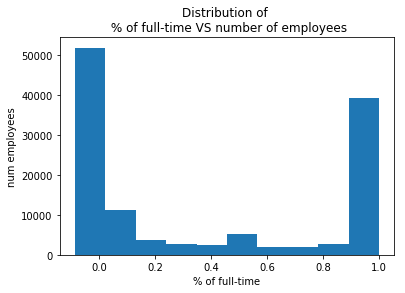

In [6]:
# Create a list of the numeric columns to be used in further steps
NUMERIC_COLUMNS = ['FTE', 'Total']

# Create a temporary dataframe with non-null FTE values
df_hist = df['FTE'].dropna()

# Create the histogram of FTE values that are less than 1.1
plt.hist(df_hist[df_hist <= 1])

# Add title and labels
plt.title('Distribution of \n % of full-time VS number of employees')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

# Display the histogram
plt.show()

 Looks like the FTE column is bimodal. That is, there are some part-time and some full-time employees in the dataset


### Encode the labels as categorical variables
When we ran df.info(), we saw that there are 23 columns of type **object** and 2 columns of type **float**. We can also see that information using value_counts() on dtypes as shown below:

In [7]:
df.dtypes.value_counts()

object     23
float64     2
dtype: int64

Having **labels** as object type is inefficient and they can be converted to type **category** which will make them more efficient for our analysis purpose. So, the following steps will store labels in a separate list and convert them to category type:

In [8]:
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

# Define a lambda function to categorize labels using 'astype'
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


Now that we have categorical **labels**, lets plot the number of categories present in each of the **labels**

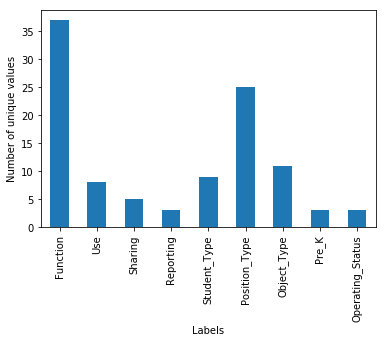

In [9]:
# Calculate number of unique values for each label
num_unique_labels = df[LABELS].apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.show()

### Measuring Success: Computing log loss with NumPy
The metric that we will use in this problem is called **'log loss'**. It is a measure of error and we need to minimize it. For our classification, log loss is given by the formula:

$$ logloss = \frac{-1}{N} [y.log(p) + (1-y).log(1-p)] $$

We can define a function **compute_log_loss** to compute the logarithmic loss between predicted and
actual when these are 1D arrays. 

In [10]:
def compute_log_loss(predicted, actual, eps=1e-14):
    ''' Computes the logarithmic loss between predicted and actual when these are 1D arrays.
            :param predicted: The predicted probabilities as floats between 0-1
            :param actual: The actual binary labels. Either 0 or 1.
            :param eps (optional): log(0) is inf, so we need to offset our predicted values slightly by eps from 0 or 1.
    '''
    predicted = np.clip(predicted, eps, 1 - eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))
    return loss

### Define a function 'multilabel_train_test_split' to split the data

The first step is to split the data into a training set and a test set. Some labels don't occur very often, but we want to make sure that they appear in both the training and the test sets so we define a function **multilabel_train_test_split** that will make sure at least **min_count** of examples of each label appear in each split


In [11]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels 'y' and returns
        the indices for a sample of size 'size' if
        'size' > 1 or 'size' * len(y) if size =< 1.
        The sample is guaranteed to have > 'min_count' of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

## Processing Text Data

### Combining text columns for tokenization
In order to get a bag-of-words representation for all of the text data in our DataFrame, we must first convert the text data in each row of the DataFrame into a single string. CountVectorizer expects each row to just be a single string, so in order to use all of the text columns, we will need a method to turn a list of strings into a single string.

The following function definition **combine_text_columns** will convert all training text data in the DataFrame to a single string per row that can be passed to the vectorizer object and made into a bag-of-words using the **.fit_transform()** method.

Note that the function uses NUMERIC_COLUMNS and LABELS to determine which columns to drop.

In [12]:
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of df to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace NaNs with blanks
    text_data.fillna("", inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

Now we can use **combine_text_columns** to convert all training text data in df to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method. This is shown in the following code:

In [13]:
# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate alphanumeric CountVectorizer
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 3284 alpha-numeric tokens in the dataset


## Training and Testing the model for Accuracy

The following are some of the tools used for data preprocessing and model instantiation:
- **Pipeline:**
In order to make our life easier, we can use scikit-learn's object Pipeline. Pipelines are a repeatable way to go from raw data to trained model. Pipeline object takes sequential list of steps where the output of one step is input to next step. 

- **FunctionTransformer:**
Any step in the pipeline must be an object that implements the fit and transform methods. The FunctionTransformer creates an object with these methods out of any Python function that we pass to it. We'll use it to help select subsets of data that can be used with pipelines.

- **FeatureUnion:**
Now that we can separate text and numeric data in our pipeline, we're ready to perform separate steps on each by nesting pipelines and using **FeatureUnion()**.

The above mentioned tools will allow us to streamline all preprocessing steps for our model, even when multiple datatypes are involved. Here, for example, we don't want to impute our text data, and we don't want to create a bag-of-words with our numeric data. Instead, we want to deal with these separately and then join the results together using FeatureUnion().

We will import the** LogisticRegression** and **one-versus-rest** classifiers in order to fit a multi-class logistic regression model for our feature data

In the end, we will still have only two high-level steps in our pipeline: **preprocessing and model instantiation**. The difference is that the first preprocessing step actually consists of a pipeline for numeric data and a pipeline for text data. The results of those pipelines are joined using FeatureUnion().

In [14]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\n% Accuracy on budget dataset: ", accuracy*100)


% Accuracy on budget dataset:  37.0895009681


## Training a Different Class of Model
To run a Random Forest Classifier instead of the logistic Regression Classifier, simply change **'clf', OneVsRestClassifier(LogisticRegression())** to **'clf', RandomForestClassifier()** in the pipeline. We also have to import **RandomForestClassifier** from **sklearn.ensemble** which has been done already in the first step of this notebook.

In [17]:
# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nRandom Forest Classifier % Accuracy on budget dataset: ", accuracy*100)


Random Forest Classifier % Accuracy on budget dataset:  90.4802947973


We can see from the Accuracy results that a Random Forest Classifier does a much better job when compared to Logistic Regression Classifier.